# K-Nearest Neighbors

### Importing Libraries

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

### Importing dataset

In [2]:
dataset = pd.read_csv('../dataset/spotify_features.csv', sep=',')
dataset.head()

,track_popularity,instrumentalness,duration_ms,energy,acousticness,album_month,album_year,danceability,loudness,liveness,genre_code,valence,artist_code
0,67.0,0.004210,162600.0,0.815,0.0724,12,2019,0.726,-4.969,0.35700,2,0.693000,4535
1,70.0,0.000023,176616.0,0.931,0.0794,7,2019,0.675,-3.432,0.19031,2,0.613000,7724
2,60.0,0.000009,169093.0,0.930,0.0287,7,2019,0.718,-3.778,0.20400,2,0.509838,6862
3,62.0,0.000000,187675.0,0.856,0.1870,7,2019,0.449,-4.788,0.17600,2,0.152000,3635
4,58.0,0.000005,207894.0,0.923,0.1460,6,2019,0.679,-6.500,0.12400,2,0.752000,2056


### Preprocessing

In [3]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=8))
])

X = dataset.drop(columns=['track_popularity'])
y = dataset['track_popularity']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)

print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (11908, 12), (11908,)
Validation set: (3970, 12), (3970,)
Test set: (3970, 12), (3970,)


### Model training

In [4]:
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=8))])

### Model Evaluation

In [5]:
train_score = model.score(X_train, y_train)
val_score = model.score(X_val, y_val)
test_score = model.score(X_test, y_test)

print(f"Train R^2: {train_score:.2f}")
print(f"Validation R^2: {val_score:.2f}")
print(f"Test R^2: {test_score:.2f}")

mae = mean_absolute_error(y_test, model.predict(X_test))
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(y_test, model.predict(X_test))
print(f'MSE: {mse:.2f}')

Train R^2: 0.27
Validation R^2: 0.08
Test R^2: 0.07
MAE: 18.76
MSE: 534.70


### Cross-validation

In [6]:
from sklearn.model_selection import cross_validate

scores = cross_validate(model, X, y, cv=6, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.030069,0.746784,-0.024222,0.284120
1,0.029052,0.738779,-0.102448,0.299513
2,0.031612,0.574841,-0.142620,0.304519
3,0.038586,0.713883,0.040263,0.264621
4,0.029055,0.660628,-0.068664,0.293222
5,0.028658,0.657788,-0.104440,0.267718


### Hyperparameter Tuning

In [7]:
# Define the pipeline
model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Define the hyperparameters to search
hyperparameters = {
    'knn__n_neighbors': [3, 5, 8, 10, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # p=1 is Manhattan distance, p=2 is Euclidean
}

# Set up GridSearchCV with cross-validation
gridsearch = GridSearchCV(model, hyperparameters, cv=5, scoring='r2', n_jobs=-1)

# Fit the GridSearch to the training data
gridsearch.fit(X_train, y_train)

# Extract and print the best estimator and its parameters
print(f"Best parameters: {gridsearch.best_params_}")
best_model = gridsearch.best_estimator_

# Evaluate the best model
train_score = best_model.score(X_train, y_train)
val_score = best_model.score(X_val, y_val)
test_score = best_model.score(X_test, y_test)
mae = (y_test - best_model.predict(X_test)).abs().mean()

print(f"Best Model Train R^2: {train_score:.2f}")
print(f"Best Model Validation R^2: {val_score:.2f}")
print(f"Best Model Test R^2: {test_score:.2f}")
print(f"Best Model MAE: {mae:.2f}")

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'distance'}
Best Model Train R^2: 1.00
Best Model Validation R^2: 0.16
Best Model Test R^2: 0.14
Best Model MAE: 17.85


#### GradientBoostingRegressor

In [8]:
# Define the pipeline
model = Pipeline([
    ('scaler', StandardScaler()),
    ('gbr', GradientBoostingRegressor())
])

# Define the hyperparameters to search
hyperparameters = {
    'gbr__n_estimators': [100, 200, 300],
    'gbr__learning_rate': [0.01, 0.05, 0.1],
    'gbr__max_depth': [3, 5, 7],
    'gbr__subsample': [0.8, 1.0]  # Use subsample for controlling overfitting
}

# Set up GridSearchCV with cross-validation
gridsearch = GridSearchCV(model, hyperparameters, cv=3, scoring='r2', n_jobs=-1)

# Fit the GridSearch to the training data
gridsearch.fit(X_train, y_train)

# Extract and print the best estimator and its parameters
print(f"Best parameters: {gridsearch.best_params_}")
best_model = gridsearch.best_estimator_

# Evaluate the best model
train_score = best_model.score(X_train, y_train)
val_score = best_model.score(X_val, y_val)
test_score = best_model.score(X_test, y_test)
mae = (y_test - best_model.predict(X_test)).abs().mean()

print(f"Best Model Train R^2: {train_score:.2f}")
print(f"Best Model Validation R^2: {val_score:.2f}")
print(f"Best Model Test R^2: {test_score:.2f}")
print(f"Best Model MAE: {mae:.2f}")

Best parameters: {'gbr__learning_rate': 0.05, 'gbr__max_depth': 7, 'gbr__n_estimators': 300, 'gbr__subsample': 0.8}
Best Model Train R^2: 0.68
Best Model Validation R^2: 0.25
Best Model Test R^2: 0.23
Best Model MAE: 17.13


### Cross-validation #2

In [9]:
scores = cross_validate(model, X, y, cv=6, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,3.440839,0.004508,-0.082533,0.219530
1,3.436209,0.004520,0.087856,0.223755
2,3.386667,0.004521,-0.064476,0.236482
3,3.448826,0.004520,0.126573,0.198268
4,3.412061,0.004506,0.023981,0.217473
5,3.407946,0.004507,0.055023,0.187171


### Ensemble

In [10]:
# Split dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Define individual models
gbr = Pipeline([('scaler', StandardScaler()), ('gbr', GradientBoostingRegressor())])
knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])
rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42))])

# Define the ensemble regressor with VotingRegressor
voting_regressor = VotingRegressor(estimators=[
    ('gbr', gbr),
    ('knn', knn),
    ('rf', rf)
])

# Define hyperparameters for GradientBoostingRegressor within GridSearchCV
hyperparameters = {
    'gbr__gbr__n_estimators': [100, 200, 300],
    'gbr__gbr__learning_rate': [0.01, 0.05, 0.1],
    'gbr__gbr__max_depth': [3, 5, 7],
    'gbr__gbr__subsample': [0.8, 1.0],
}

# Set up GridSearchCV with the voting ensemble
gridsearch = GridSearchCV(voting_regressor, hyperparameters, cv=3, scoring='r2', n_jobs=-1)

# Train the ensemble model with GridSearchCV
gridsearch.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = gridsearch.best_estimator_
print(f"Best parameters: {gridsearch.best_params_}")

# Evaluate on train, validation, and test sets
train_score = best_model.score(X_train, y_train)
val_score = best_model.score(X_val, y_val)
test_score = best_model.score(X_test, y_test)

# Print R^2 scores
print(f"Best Model Train R^2: {train_score:.2f}")
print(f"Best Model Validation R^2: {val_score:.2f}")
print(f"Best Model Test R^2: {test_score:.2f}")

# Calculate and print error metrics on the test set
y_test_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
print(f"Best Model MAE: {mae:.2f}")
print(f"Best Model MSE: {mse:.2f}")

KeyboardInterrupt: 

### Visualizations

#### Feature Importance

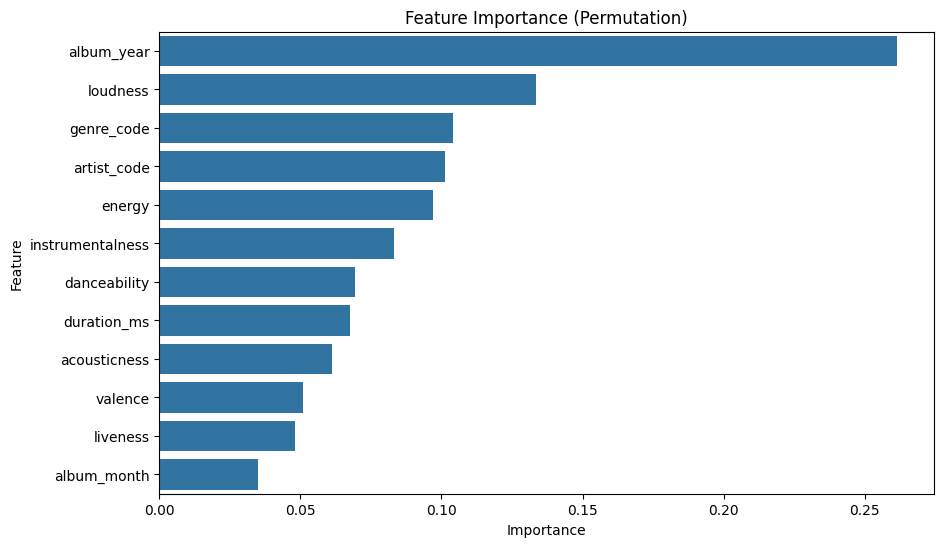

In [13]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Permutation)')
plt.show()

#### Prediction vs Actual

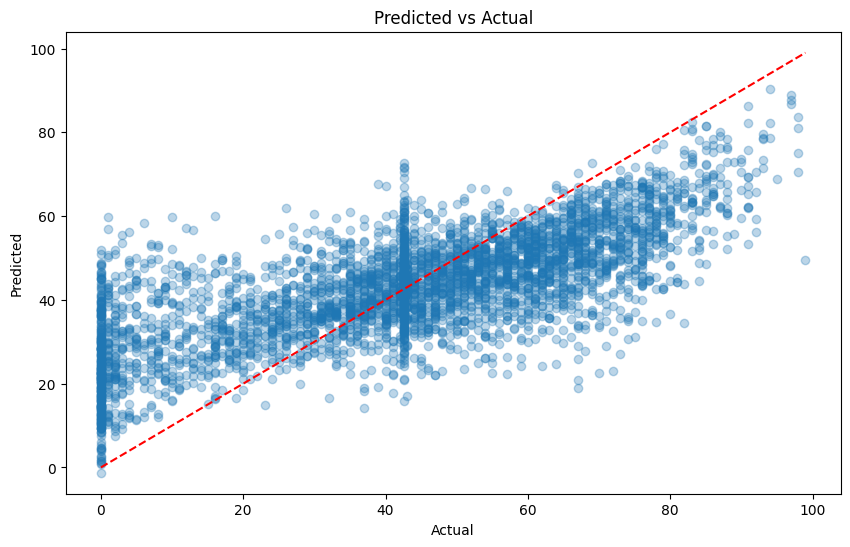

In [14]:
y_pred = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

#### Residuals

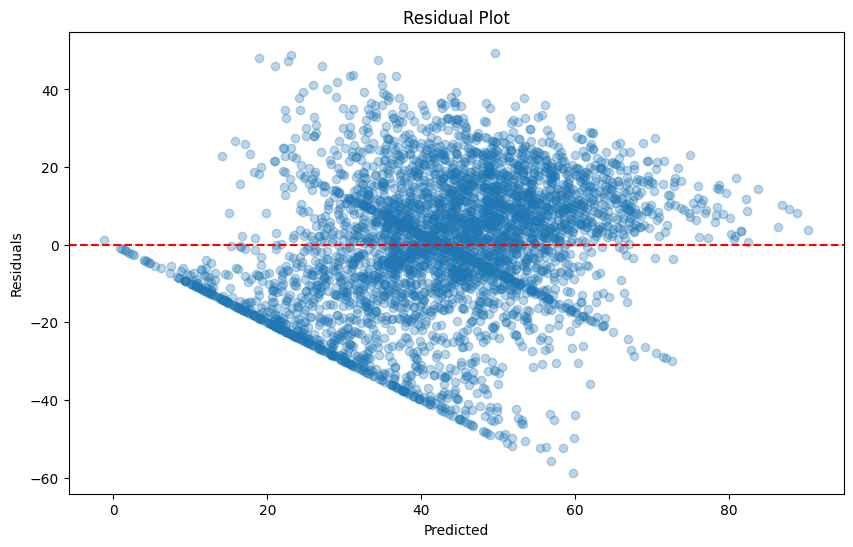

In [15]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()